In [1]:
import numpy as np
import networkx as nx
import network
import base
import igraph as ig
import itertools
import pandas as pd
from skimage.morphology import disk
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def lattice(absc,ordi,w_absc=None,w_ordi=None):
    x = np.arange(0, absc, 1)
    y = np.arange(0, ordi, 1)
    positions =list(itertools.product(x, y))
    G = nx.Graph()
    node_dict_list = list()
    for _id,pos in zip(range(len(positions)),positions):
        node_dict_list.append((_id,dict([('o',pos)])))
    G.add_nodes_from(node_dict_list)
    
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if (G.nodes[i]['o'][0]-G.nodes[j]['o'][0])==1 and (G.nodes[i]['o'][1]==G.nodes[j]['o'][1]):
                G.add_edge(i,j,weight=w_absc)
            if (G.nodes[i]['o'][1]-G.nodes[j]['o'][1])==1 and (G.nodes[i]['o'][0]==G.nodes[j]['o'][0]):
                G.add_edge(i,j,weight=w_ordi)
    return G

def removal(G,HRate,VRate):
    def HV(node_i, node_j):
        H = abs(node_i['o'][0] - node_j['o'][0]) == 1
        V = abs(node_i['o'][1] - node_j['o'][1]) == 1
        return H, V
        
    for i,j in G.edges():
        H,V = HV(G.nodes(data=True)[i], G.nodes(data=True)[j])
        if H and np.random.rand() < HRate:
            G.remove_edge(i, j)
        if V and np.random.rand() < VRate:
            G.remove_edge(i, j)
            
    return G



In [ ]:
G = lattice(50,50)
Ax_df = []
Ay_df = []
HRate_df = []
VRate_df = []
for i in np.linspace(0.0,0.01,5):
    for j in np.linspace(0.0,0.01,5):
        Gb = removal(G, i,j)
        Ax,Ay = gyration_moments_3(ig.Graph.from_networkx(Gb), sampling=0.1)
        Ax_df.append(Ax)
        Ay_df.append(Ay)
        HRate_df.append(i)
        VRate_df.append(j)
        
df = pd.DataFrame(columns=['HRate','VRate','Ax','Ay'])
df['HRate'] = HRate_df
df['VRate'] = VRate_df
df['Ax'] = Ax_df
df['Ay'] = Ay_df
df['Ax/Ay'] = df['Ax']/df['Ay']
df['H/R'] = df['HRate']/df['VRate']

# Particle gyrations

<ipython-input-178-d193213a1f0a>:6: RuntimeWarning: covariance is not positive-semidefinite.
  points = np.random.multivariate_normal(mean=(1,1), cov=cov, size=(1000,))


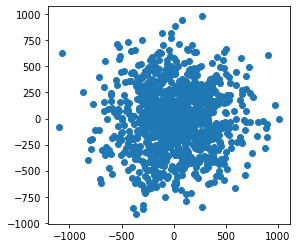

In [178]:
import numpy as np
import matplotlib.pyplot as plt
cov=[[1.5, 0.9], [0.9, 1]]
#cov=A
cov=np.array([[  747.28416, 94775.14574],[94775.14574,  5443.88611]])
points = np.random.multivariate_normal(mean=(1,1), cov=cov, size=(1000,))
points = np.vstack((points.T,np.zeros(len(points)))).T
fix,ax = plt.subplots()

thetar = np.pi/4
r = R.from_quat([0, 0, np.cos(thetar/2), np.sin(thetar/2)])
mat = r.as_matrix()

ax.scatter(points.T[0],points.T[1])
plt.axis('scaled')
plt.show()



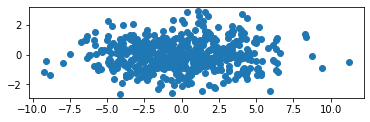

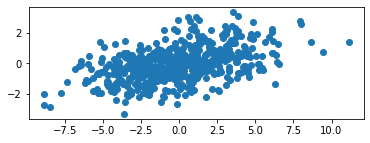

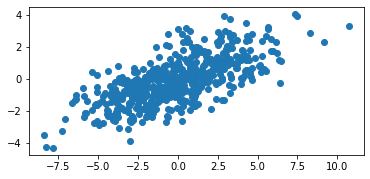

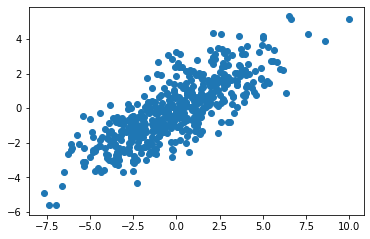

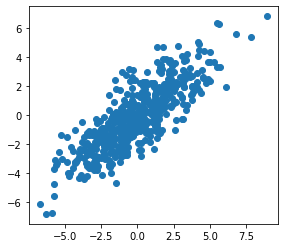

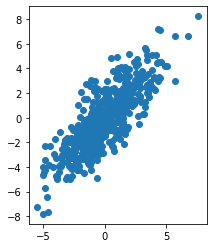

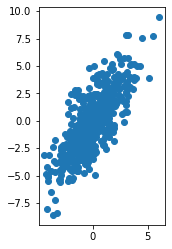

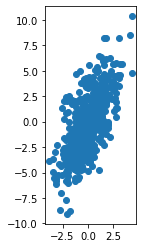

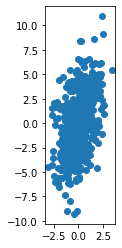

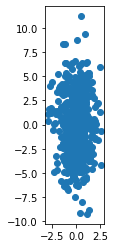

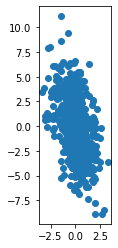

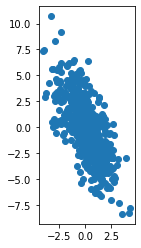

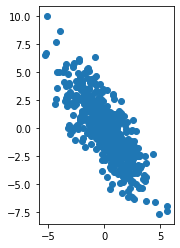

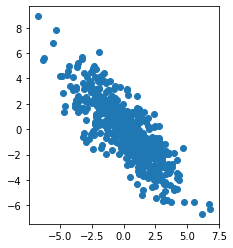

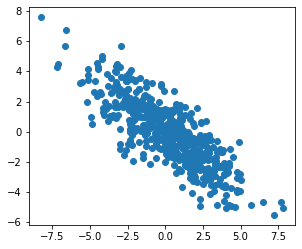

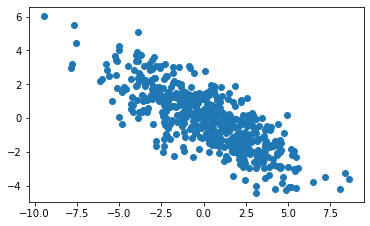

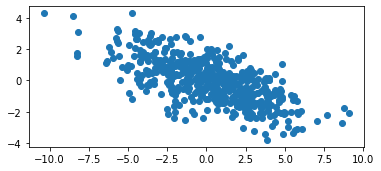

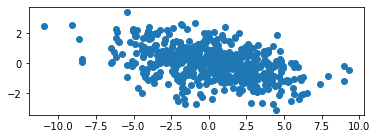

In [246]:
M = []
Axl = []
Ayl = []
points = np.random.multivariate_normal(mean=(0,0), cov=[[10, 0], [0, 1]], size=(500,))
points = np.vstack((points.T,np.zeros(len(points)))).T
from scipy.spatial.transform import Rotation as R
thetas = np.linspace(0,170,18)
#thetas = (0,0.1)
for theta in thetas:
    thetar = theta*np.pi/180
    r = R.from_quat([0, 0, np.cos(thetar/2), np.sin(thetar/2)])
    mat = r.as_matrix()
    pointsN = np.matmul(points, mat)
    plt.scatter(pointsN.T[0], pointsN.T[1])
    plt.axis('scaled')
    plt.show()
    Ax,Ay,Axy,Ayx = 0,0,0,0
    for i in pointsN:
        for j in pointsN:
            Ax  = Ax  + (i[0]-j[0])**2
            Ay  = Ay  + (i[1]-j[1])**2
            Axy = Axy + (i[0]-j[1])*(i[1]-j[0])
    M.append(np.array([[Ax,Axy,0],[Axy,Ay,0],[0,0,0]]))

M = np.asarray(M)  

evals,rot_mat = np.linalg.eig(M)
r = R.from_matrix(rot_mat)
r = r.as_rotvec(degrees=True)
r

points3 = np.matmul(points, rot_mat)

# Model networks

In [ ]:
import network
g = network.ResistiveNetwork('TestData/Model_Systems/Rectangle1')
g.binarize()
Ax_df = []
Ay_df = []
O_eff_df = []
thetas = np.linspace(0,350,72)
for theta in thetas:
    g.stack_to_circular_gsd(274,name='rot_skel.gsd', rotate=theta)
    g.G_u()
    g.potential_distribution(0, [0,100], [540-100,540], R_j=100)
    L = g.L
    Q = np.linalg.pinv(L)
    O_eff = Q[-1,-1]+Q[-2,-2]-2*Q[-1,-2]
    Ax_df.append(Ax)
    Ay_df.append(Ay)
    O_eff_df.append(O_eff)
    base.Node_labelling(g, g.P, 'P', 'Results.gsd')
    Ax,Ay = gyration_moments_3(g.Gr,sampling=1)
    
df = pd.DataFrame(columns=['Theta', 'Ax','Ay', 'O_eff'])
df['Theta'] = thetas
df['Ax'] = Ax_df
df['Ay'] = Ay_df
df['O_eff'] = O_eff_df

In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']

In [ ]:
#Ax/Ay - Selectivity
fig, ax1 = plt.subplots()

ax1.scatter(df['Theta'],df['O_eff_PERP'], label=r'$Y_\Omega$', color='tab:blue')
ax1.set_xlabel(r'$\theta\/(deg)$')
ax1.set_ylabel(r'$Y_\Omega$')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.scatter(df['Theta'],df['Ax'], label=r'$A_x/A_y$', color='tab:orange')
#ax2.scatter(df['Theta'],df['Ax/Ay'], label=r'$A_x/A_y$', color='tab:orange')
ax2.set_ylabel(r'$A_x/A_y$')
ax2.set_yscale('log')

fig.legend()
plt.show()

In [ ]:
plt.scatter(df['Theta'],df['Ax'])
plt.scatter(df['Theta'],df['Ay'])
plt.yscale("log")
plt.show()

# Experimental networks: AgNWN

In [ ]:

import pandas as pd
df = pd.read_csv('/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um/Binarized/Rotations/ObjectImplementation/AgNWN_10um_Rweight_circleGSD_distanceGyration.csv')


In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']
plt.scatter(df['Theta'], 1/df['Selectivity'])
plt.scatter(df['Theta'], df['Ax/Ay'])
plt.yscale('log')
plt.show

In [ ]:
df['O_eff_PERP'] = np.roll(df['O_eff'].values, -9)
df['Selectivity'] = (df['O_eff_PERP']/df['O_eff'])**1
df['Ax/Ay'] = df['Ax']/df['Ay']
plt.scatter(df['Theta'], df['Ax'])
plt.scatter(df['Theta'], df['Ay'])
plt.yscale('log')
plt.show

In [ ]:
import gsd.hoomd
traj = gsd.hoomd.open(name='/Users/alaink/Software/StructuralGTEdits/StructuralGT/TestData/AgNWN_10um/Binarized/Rotations/ObjectImplementation/Cweight_circle_displacement.gsd')
AxL = []
AyL = []
for snap in traj:
    points = snap.particles.position[snap.particles.typeid==1]
    Ax,Ay = 0,0
    for i in points:
        for j in points:
            Ax  = Ax  + (i[0]-j[0])**2
            Ay  = Ay  + (i[1]-j[1])**2
    AxL.append(Ax)
    AyL.append(Ay)


# Experimental networks: Mxene (with diagonalisation)

In [3]:
def gyration_moments_3(G, sampling=1):
#Serial implementation
    Ax=0
    Ay=0
    Axy=0
    Ayx=0
    node_count = np.asarray(list(range(G.vcount())))
    mask = np.random.rand(G.vcount()) > (1-sampling)
    trimmed_node_count = node_count[mask]
    for i in trimmed_node_count:
        for j in trimmed_node_count:
            if i >= j:    #Symetric matrix
                continue
            
            path = G.get_shortest_paths(i,to=j, weights='Resistance')
            Ax_term  = 0
            Ay_term  = 0
            Axy_term = 0
            Ayx_term = 0
            for hop_s,hop_t in zip(path[0][0:-1],path[0][1::]):
                weight = G.es[G.get_eid(hop_s,hop_t)]['Conductance']
                Ax_term  = Ax_term  + weight*(((int(G.vs[hop_s]['o'][0])-int(G.vs[hop_t]['o'][0])))**2)
                Ay_term  = Ay_term  + weight*(((int(G.vs[hop_s]['o'][1])-int(G.vs[hop_t]['o'][1])))**2)
                Axy_term = Axy_term + weight*(((int(G.vs[hop_s]['o'][1])-int(G.vs[hop_t]['o'][1])))*((int(G.vs[hop_s]['o'][0])-int(G.vs[hop_t]['o'][0]))))
                #Ayx_term = Ayx_term + ((weight*(int(G.vs[hop_s]['o'][0])-int(G.vs[hop_t]['o'][1])))*((int(G.vs[hop_s]['o'][1])-int(G.vs[hop_t]['o'][0]))))
            Ax  = Ax  + (Ax_term)
            Ay  = Ay  + (Ay_term)
            Axy = Axy + (Axy_term)
            #Ayx = Ayx + (Ayx_term)
            A = np.array([[Ax,Axy,0],[Axy,Ay,0],[0,0,0]])
    return A

In [58]:
scale=1

img_options={"Thresh_method":1, "gamma": 3.45, "md_filter": 1, "g_blur": 1, "autolvl": 1,
             "fg_color":1, "laplacian": 0, "scharr":0, "sobel":0 , "lowpass": 1, "asize": int((103*scale))*2+1,
             "bsize":int((30*scale))*2+1, "wsize": int((10*scale))*2+1, "thresh": 127}


#N = network.ResistiveNetwork('TestData/AgNWN_10um')
N = network.ResistiveNetwork('TestData/AgNWN_iso/Single')
#N = network.ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/30_003')
#N = network.ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_021')
#N = network.ResistiveNetwork('TestData/Mxene/2')
#N = network.ResistiveNetwork('TestData/AgNWN_iso/LargeSet/200s/004')
#N.binarize(options_dict=img_options)


N.stack_to_circular_gsd(875, debubble=[disk(2)])
#N.stack_to_gsd(crop=[L1,L3,L2,L4], debubble=[disk(2)])
N.G_u()

N.Gr = base.sub_G(N.Gr)
measuring_graph = base.add_weights(N, weight_type='Resistance', R_j=5)
measuring_graph = base.add_weights(N, weight_type='Conductance', R_j=5)


A = gyration_moments_3(measuring_graph,sampling=0.2)


from scipy.spatial.transform import Rotation as R
evals,rot_mat = np.linalg.eig(A)

    
r = R.from_matrix(rot_mat)
r = -r.as_rotvec(degrees=True)
if evals[0]<evals[1]: r = r + 90
if r[2] < 0: r = r + 360
print(rot_mat)
print('evals are ', evals)
print(r)

Ran stack_to_gsd() in  2.8467609882354736 for gsd with  43253 particles
Ran debubble in  1.4735989570617676 for an image with shape  (1, 1764, 2046)
gsd_to_G canvas has shape  (1748, 1750)
[[ 11 831]]
(0, 1, array([[ 11, 831],
       [ 10, 830],
       [ 10, 829],
       [  9, 828],
       [  9, 827],
       [  9, 826],
       [  9, 825],
       [  9, 824],
       [  9, 823],
       [  9, 822],
       [ 10, 821],
       [ 10, 820],
       [ 10, 819],
       [ 11, 818],
       [ 11, 817],
       [ 12, 816]], dtype=int16))
Ran gsd_to_G in  4.305454969406128 for a graph with  1284 nodes.
pre sub has  1284  nodes
post sub has  151  nodes
[[ 0.89075391 -0.45448594  0.        ]
 [ 0.45448594  0.89075391  0.        ]
 [ 0.          0.          1.        ]]
evals are  [2324779.54469777 1359453.55526568       0.        ]
[360.         360.         332.96813658]


Ran stack_to_gsd() in  2.5080690383911133 for gsd with  38715 particles
Ran debubble in  1.4360711574554443 for an image with shape  (1, 1757, 2033)
gsd_to_G canvas has shape  (1700, 1700)
[[  3 794]]
(0, 4, array([[  3, 794],
       [  3, 793],
       [  3, 792],
       [  4, 791],
       [  4, 790],
       [  4, 789],
       [  4, 788]], dtype=int16))
Ran gsd_to_G in  4.019308090209961 for a graph with  1269 nodes.


<ipython-input-3-260647fa1f9d>:15: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  path = G.get_shortest_paths(i,to=j, weights='Resistance')


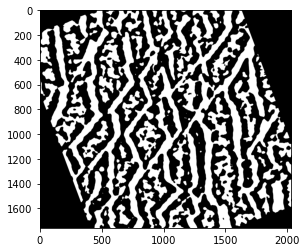

Ran stack_to_gsd() in  2.1956071853637695 for gsd with  38836 particles
Ran debubble in  1.4212837219238281 for an image with shape  (1, 1758, 2048)
gsd_to_G canvas has shape  (1694, 1698)
[[ 17 926]]
(0, 17, array([[ 17, 926],
       [ 18, 927],
       [ 18, 928],
       [ 19, 929],
       [ 19, 930],
       [ 20, 931],
       [ 21, 932],
       [ 21, 933],
       [ 22, 934],
       [ 23, 935],
       [ 24, 936],
       [ 25, 937],
       [ 26, 938],
       [ 27, 939],
       [ 28, 940],
       [ 29, 941],
       [ 30, 942],
       [ 31, 942],
       [ 32, 943],
       [ 33, 944],
       [ 34, 945],
       [ 35, 945],
       [ 36, 945],
       [ 37, 945],
       [ 38, 946],
       [ 39, 946],
       [ 40, 946],
       [ 41, 946],
       [ 42, 946],
       [ 43, 947],
       [ 44, 947],
       [ 45, 947],
       [ 46, 947],
       [ 47, 948],
       [ 48, 948],
       [ 49, 948],
       [ 50, 949],
       [ 51, 949],
       [ 52, 950],
       [ 53, 951],
       [ 54, 952],
       [ 55,

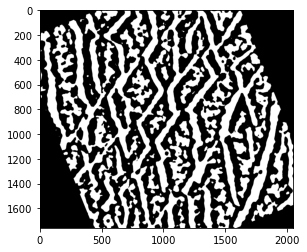

Ran stack_to_gsd() in  2.0316660404205322 for gsd with  40602 particles
Ran debubble in  1.50559401512146 for an image with shape  (1, 1742, 2036)
gsd_to_G canvas has shape  (1699, 1690)
[[  5 942]]
(0, 7, array([[  5, 942],
       [  6, 943],
       [  7, 944],
       [  8, 945],
       [  9, 946],
       [ 10, 947],
       [ 11, 948],
       [ 12, 949],
       [ 13, 950],
       [ 14, 951],
       [ 15, 951],
       [ 16, 952],
       [ 17, 953],
       [ 18, 954],
       [ 19, 955],
       [ 20, 955],
       [ 21, 956],
       [ 22, 957],
       [ 23, 958],
       [ 24, 958],
       [ 25, 959],
       [ 26, 960],
       [ 27, 961],
       [ 28, 961],
       [ 29, 961],
       [ 30, 961],
       [ 31, 961],
       [ 32, 961],
       [ 33, 961],
       [ 34, 961],
       [ 35, 961],
       [ 36, 961],
       [ 37, 961],
       [ 38, 961],
       [ 39, 961],
       [ 40, 961],
       [ 41, 961],
       [ 42, 962]], dtype=int16))
Ran gsd_to_G in  4.470808029174805 for a graph with  1398

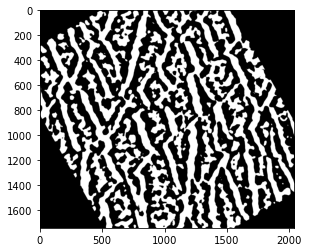

Ran stack_to_gsd() in  2.1837639808654785 for gsd with  34770 particles
Ran debubble in  1.59934401512146 for an image with shape  (1, 1766, 2047)
gsd_to_G canvas has shape  (1693, 1695)
[[  2 806]]
(0, 1, array([[  2, 806],
       [  3, 806],
       [  4, 806],
       [  5, 805],
       [  6, 804],
       [  7, 803],
       [  8, 802],
       [  9, 802],
       [ 10, 802]], dtype=int16))
Ran gsd_to_G in  3.9968619346618652 for a graph with  1091 nodes.


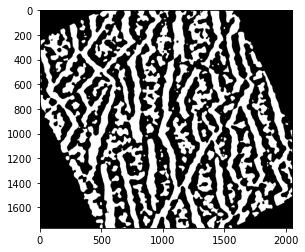

Ran stack_to_gsd() in  2.1308231353759766 for gsd with  34271 particles
Ran debubble in  1.3743586540222168 for an image with shape  (1, 1749, 2036)
gsd_to_G canvas has shape  (1696, 1700)
[[ 15 867]]
(0, 3, array([[ 15, 867],
       [ 16, 867],
       [ 17, 867],
       [ 18, 866],
       [ 19, 867],
       [ 20, 867],
       [ 21, 867]], dtype=int16))
Ran gsd_to_G in  4.0025248527526855 for a graph with  1035 nodes.


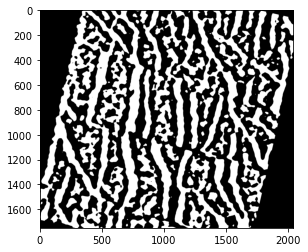

Ran stack_to_gsd() in  2.3559389114379883 for gsd with  35362 particles
Ran debubble in  1.613732099533081 for an image with shape  (1, 1740, 2036)
gsd_to_G canvas has shape  (1698, 1700)
[[ 13 965]]
(0, 7, array([[ 13, 965],
       [ 13, 964],
       [ 13, 963],
       [ 13, 962],
       [ 13, 961],
       [ 13, 960],
       [ 13, 959],
       [ 14, 958],
       [ 14, 957],
       [ 14, 956],
       [ 14, 955],
       [ 14, 954],
       [ 14, 953],
       [ 14, 952],
       [ 14, 951],
       [ 14, 950],
       [ 14, 949],
       [ 14, 948],
       [ 14, 947],
       [ 14, 946],
       [ 14, 945],
       [ 14, 944],
       [ 14, 943],
       [ 14, 942],
       [ 14, 941],
       [ 14, 940],
       [ 14, 939],
       [ 14, 938],
       [ 14, 937],
       [ 14, 936],
       [ 14, 935],
       [ 14, 934],
       [ 14, 933],
       [ 14, 932],
       [ 14, 931],
       [ 14, 930],
       [ 14, 929],
       [ 15, 928],
       [ 15, 927],
       [ 15, 926],
       [ 15, 925],
       [ 15, 9

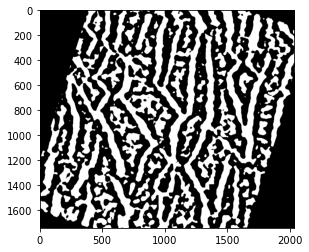

Ran stack_to_gsd() in  2.5450692176818848 for gsd with  34734 particles
Ran debubble in  1.5346388816833496 for an image with shape  (1, 1757, 2047)
gsd_to_G canvas has shape  (1700, 1697)
[[  8 835]]
(0, 1, array([[  8, 835],
       [  9, 834],
       [ 10, 833],
       [ 11, 832],
       [ 12, 831],
       [ 13, 830],
       [ 14, 829],
       [ 15, 828],
       [ 16, 827],
       [ 17, 826],
       [ 18, 825],
       [ 19, 824],
       [ 20, 823]], dtype=int16))
Ran gsd_to_G in  4.273926258087158 for a graph with  1038 nodes.


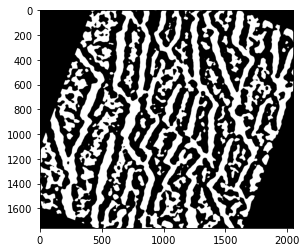

In [77]:
img_list = []
flow_vector_list = []
evals_list = []
O=[]
samples = (3,4)
samples = (1,2,3,4,5,6,7)
for i in samples:
    N = network.ResistiveNetwork('TestData/Mxene/'+str(i))
    N.stack_to_circular_gsd(850, debubble=[disk(2)])
    #N.stack_to_gsd(crop = [0,1700,0,1700], debubble=[disk(2)])
    N.G_u()

    #N.Gr = base.sub_G(N.Gr)
    measuring_graph = base.add_weights(N, weight_type='Resistance', R_j=5)
    measuring_graph = base.add_weights(N, weight_type='Conductance', R_j=5)
    base.G_to_gsd(N.Gr, N.stack_dir + '/measuring_graph.gsd')
    A = gyration_moments_3(measuring_graph,sampling=0.1)

    from scipy.spatial.transform import Rotation as R
    evals,rot_mat = np.linalg.eig(A)

    r = R.from_matrix(rot_mat)
    r = -r.as_rotvec(degrees=True)
    if evals[0]<evals[1]:
        evals = [evals[1],evals[0]]
        r[2] = r[2] + 90
        flow_vector = rot_mat[0]
    else:
        flow_vector = rot_mat[1]
    if r[2] < 0: r = r + 360
    
    img_bin = cv.imread(N.stack_dir+'/slice0.tiff') #Original image
    image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(image_center, r[2], 1.0)
    rot_img = cv.warpAffine(img_bin, rot_mat, img_bin.shape[1::-1], flags=cv.INTER_LINEAR)
    img_list.append(img_bin)
    flow_vector_list.append(flow_vector)
    evals_list.append(evals)
    plt.imshow(rot_img)
    plt.show()
    
    """
    N.stack_to_circular_gsd(850, debubble=[disk(1)], rotate=r[2], name='rot_skel.gsd')
    N.G_u()
    N.Gr = base.sub_G(N.Gr)
    N.potential_distribution(1, [0,100], [1600,1700], R_j=0)
    O.append(N.effective_resistance())
    N.potential_distribution(0, [0,100], [1600,1700], R_j=0)
    O.append(N.effective_resistance())
    """

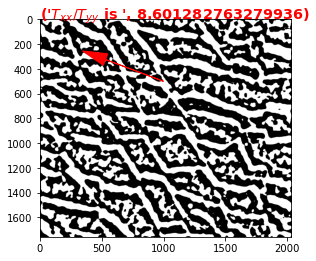

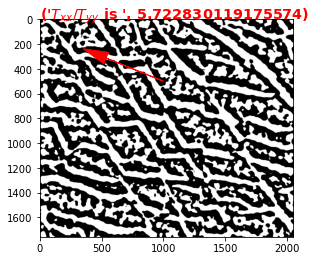

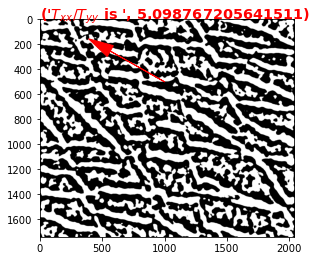

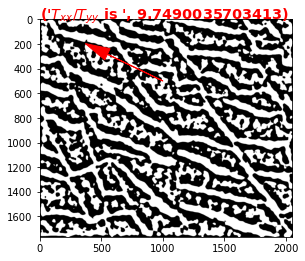

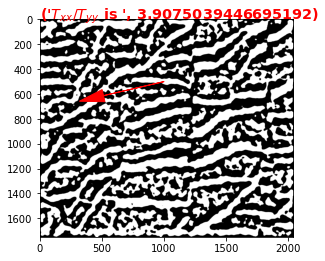

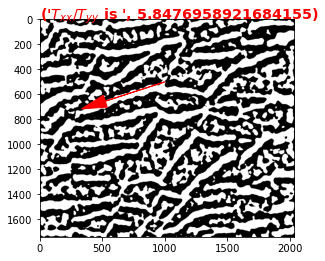

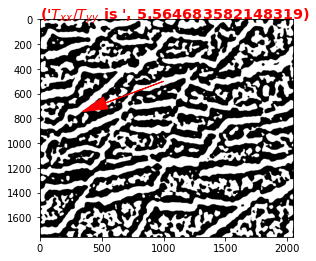

In [78]:
for img, vector, evals, in zip(img_list, flow_vector_list, evals_list):
    fig, ax1 = plt.subplots()
    plt.arrow(1000,500,(vector[0])*500,(vector[1])*500, head_width=100, head_length=200,ec='red',fc='red')
    plt.annotate(str((r'$T_{xx}/T_{yy}$ is ', evals[0]/evals[1])) ,(0,0), color='red',size='x-large',weight='bold')
    plt.imshow(img)
    plt.show()

# Experimental networks (AgNWN)

In [5]:
dir(base)

['ExpProcess',
 'G_analysis_lite',
 'G_labelling',
 'G_to_gsd',
 'GetWeights_3d',
 'Q_img',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'add_weights',
 'binary_closing',
 'canvas_to_G',
 'canvas_to_gsd',
 'cm',
 'connector',
 'csv',
 'cv',
 'debubble',
 'dim_red',
 'error',
 'gsd',
 'gsd_crop',
 'gsd_to_G',
 'gsd_to_canvas',
 'gsd_to_pos',
 'gyration_moments',
 'gyration_moments_2',
 'ig',
 'igraph_ANC',
 'igraph_avg_indices',
 'igraph_calcs',
 'json',
 'np',
 'os',
 'oshift',
 'parallel_gyration',
 'pd',
 'plt',
 'process_image',
 'shift',
 'shutil',
 'skeletonize',
 'skeletonize_3d',
 'sknw',
 'stack_analysis',
 'stack_to_G',
 'stack_to_canvas',
 'stack_to_gsd',
 'sub_G',
 'time',
 'voltage_distribution',
 'weighted_Laplacian',
 'write_averaged']

In [3]:
N = network.ResistiveNetwork('TestData/AgNWN_Aligned/GT_Subset/100_020')
img_bin = cv.imread(N.stack_dir+'/slice0.tiff') #Original image
image_center = tuple(np.array(img_bin.shape[1::-1]) / 2)
short_length = img_bin.shape[img_bin.shape == max(img_bin.shape)]
long_length = max(img_bin.shape)
ISS = (short_length**2/2)**0.5
L1 = int((long_length - ISS)/2)
L3 = int(ISS+L1)
L2 = int((short_length - ISS)/2)
L4 = int(ISS+L2)
crop = [L1,L3,L2,L4]

N.stack_to_gsd(crop=crop, debubble=[disk(1)])
N.G_u()
N.Gr = base.sub_G(N.Gr)
N.potential_distribution(1, [0,100], [1600,1700], R_j=0)
N.Node_labelling(N.P, 'P', 'test1.gsd')

Ran stack_to_gsd() in  0.20289397239685059 for gsd with  59975 particles
Ran debubble in  0.22084498405456543 for an image with shape  (1, 719, 719)
gsd_to_G canvas has shape  (719, 719)
[[ 0 25]]
(0, 41, array([[ 0, 25],
       [ 0, 26],
       [ 0, 27],
       [ 0, 28],
       [ 0, 29],
       [ 1, 30],
       [ 1, 31],
       [ 1, 32],
       [ 1, 33],
       [ 2, 34],
       [ 2, 35],
       [ 2, 36],
       [ 2, 37],
       [ 2, 38],
       [ 3, 39],
       [ 3, 40],
       [ 4, 41],
       [ 5, 42]], dtype=int16))
Ran gsd_to_G in  2.210024833679199 for a graph with  5988 nodes.
pre sub has  5988  nodes
post sub has  3298  nodes
gsd_to_G canvas has shape  (719, 719)
[[ 0 25]]
(0, 41, array([[ 0, 25],
       [ 0, 26],
       [ 0, 27],
       [ 0, 28],
       [ 0, 29],
       [ 1, 30],
       [ 1, 31],
       [ 1, 32],
       [ 1, 33],
       [ 2, 34],
       [ 2, 35],
       [ 2, 36],
       [ 2, 37],
       [ 2, 38],
       [ 3, 39],
       [ 3, 40],
       [ 4, 41],
       [ 5, 4

implicit data copy when writing chunk: log/particles/P
